# Airbnb in Paris: geographic data visualization and other ideas

This notebook is inteded to explore the distriution of airbnbs in Paris. Data are available at http://insideairbnb.com . 
So far, I concentrate on data visualization and try to learn to use the libraries geopandas and geoplot for data visualisation. I start with some simple trends such as price/district, and review score/district. At the end I list some open directions to dig 

In [1]:
import pandas as pd
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import numpy as np


import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt



# Import, explore and clean data

In [2]:
f_large='data/listings_large.csv'
df_large = pd.read_csv(f_large)

df_large.head(2)
df_large.shape

id                        listing_url       scrape_id last_scraped  \
0  3109  https://www.airbnb.com/rooms/3109  20180607123430   2018-06-08   
1  5396  https://www.airbnb.com/rooms/5396  20180607123430   2018-06-08   

                             name  \
0                    zen and calm   
1  Explore the heart of old Paris   

                                             summary  \
0  Appartement très calme de 50M2 Belle lumière D...   
1  Cozy, well-appointed and graciously designed s...   

                                               space  \
0                   I bedroom appartment in Paris 14   
1  Small, well appointed studio apartment at the ...   

                                         description experiences_offered  \
0                   I bedroom appartment in Paris 14                none   
1  Cozy, well-appointed and graciously designed s...                none   

                               neighborhood_overview        ...          \
0                                                NaN        ...           
1  You are within walking distance to the Louvre,...        ...           

  requires_license license jurisdiction_names instant_bookable  \
0                t     NaN            {Paris}                f   
1                t     NaN            {Paris}                t   

  is_business_travel_ready          cancellation_policy  \
0                        f                     flexible   
1                        f  strict_14_with_grace_period   

   require_guest_profile_picture require_guest_phone_verification  \
0                              f                                f   
1                              f                                f   

   calculated_host_listings_count  reviews_per_month  
0                               1               0.28  
1                               1               1.20  

[2 rows x 96 columns]

(60529, 96)

In [3]:
df_large.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60529 entries, 0 to 60528
Data columns (total 96 columns):
id                                  60529 non-null int64
listing_url                         60529 non-null object
scrape_id                           60529 non-null int64
last_scraped                        60529 non-null object
name                                60453 non-null object
summary                             58669 non-null object
space                               40598 non-null object
description                         60463 non-null object
experiences_offered                 60529 non-null object
neighborhood_overview               35442 non-null object
notes                               18410 non-null object
transit                             37914 non-null object
access                              28984 non-null object
interaction                         28100 non-null object
house_rules                         29129 non-null object
thumbnail_url          

The dataset has a lot of information. For now, I keep only the columns listed below

In [4]:
my_cols = ['id', 'host_id', 'host_since', 'host_is_superhost', 'neighbourhood_cleansed',
          'latitude', 'longitude', 'room_type','square_feet', 'price', 'availability_365',
          'number_of_reviews', 'first_review', 'last_review', 'review_scores_rating',
          'review_scores_location', 'review_scores_value', 'reviews_per_month', 
           'calculated_host_listings_count', 'beds','review_scores_accuracy',
           'review_scores_cleanliness','review_scores_communication',
          ]
df = df_large[my_cols]

Check scale of reviews

In [5]:
df_large.review_scores_rating.unique()
df_large.review_scores_location.unique()
df_large.review_scores_value.unique()
df_large.review_scores_accuracy.unique()
df_large.review_scores_cleanliness.unique()
df_large.review_scores_communication.unique()

array([100.,  94.,  96.,  95.,  98.,  99.,  97.,  88.,  93.,  89.,  nan,
        91.,  92.,  86.,  75.,  80.,  85.,  90.,  83.,  71.,  87.,  77.,
        84.,  63.,  76.,  60.,  81.,  82.,  20.,  78.,  73.,  72.,  79.,
        40.,  74.,  64.,  69.,  70.,  67.,  56.,  30.,  53.,  65.,  68.,
        50.,  66.,  57.,  47.,  55.,  62.,  36.,  52.,  27.,  58.,  48.])

array([10., nan,  9.,  8.,  7.,  6.,  4.,  2.,  5.])

array([10.,  9., nan,  8.,  7.,  6.,  2.,  4.,  3.,  5.])

array([10.,  9., nan,  8.,  7.,  6.,  2.,  4.,  5.,  3.])

array([10.,  9., nan,  8.,  6.,  5.,  7.,  4.,  2.,  3.])

array([10., nan,  9.,  8.,  7.,  2.,  6.,  5.,  4.,  3.])

REviews go from 1 to 10 (including 1/2 stars) except review_scores_rating. I  renormalize review_scores_rating 

In [6]:
df.review_scores_rating = df_large.review_scores_rating/10

List of neighborhoods

In [7]:
df.neighbourhood_cleansed.value_counts()

Buttes-Montmartre      6927
Popincourt             6018
Vaugirard              4466
Entrepôt               4179
Batignolles-Monceau    4073
Ménilmontant           3674
Buttes-Chaumont        3434
Passy                  3149
Temple                 2871
Opéra                  2714
Reuilly                2453
Observatoire           2365
Gobelins               2203
Panthéon               2043
Hôtel-de-Ville         1955
Bourse                 1862
Luxembourg             1773
Palais-Bourbon         1692
Élysée                 1492
Louvre                 1186
Name: neighbourhood_cleansed, dtype: int64

In Paris, number of arrondissment is used, not name. convert names->numbers

In [8]:
n_to_arr_dict = {'Buttes-Montmartre':18,
                 'Popincourt':11,
                 'Vaugirard':15,
                 'Entrepôt':10,
                 'Batignolles-Monceau':17,
                 'Ménilmontant':20,
                 'Buttes-Chaumont':19,
                 'Passy':16,
                 'Temple':3,
                 'Opéra':9,
                 'Reuilly':12,
                 'Observatoire':14,
                 'Gobelins':13,
                 'Panthéon':5,
                 'Hôtel-de-Ville':4,
                 'Bourse':2,
                 'Luxembourg':6,
                 'Palais-Bourbon':7,
                 'Élysée':8,
                 'Louvre':1
}

df['arrondissement']=df.neighbourhood_cleansed.map(n_to_arr_dict)

In [9]:
# Check missing

df.isnull().sum()

id                                    0
host_id                               0
host_since                           29
host_is_superhost                    29
neighbourhood_cleansed                0
latitude                              0
longitude                             0
room_type                             0
square_feet                       58951
price                                 0
availability_365                      0
number_of_reviews                     0
first_review                      13297
last_review                       13293
review_scores_rating              14558
review_scores_location            14692
review_scores_value               14691
reviews_per_month                 13297
calculated_host_listings_count        0
beds                                 89
review_scores_accuracy            14633
review_scores_cleanliness         14607
review_scores_communication       14629
arrondissement                        0
dtype: int64

In [10]:
# price is a string (!!?!) convert to int
type(df.price[1])
df.price[:2]
import re
df.price = df.price.apply(lambda line: int(re.findall(r'\d+', line)[0]))
type(df.price[1])
df.price[:2]

str

0    $59.00
1    $93.00
Name: price, dtype: object

numpy.int64

0    59
1    93
Name: price, dtype: int64

# Choropleth maps with geoPandas

#### Load a background map with arrondissements

In [11]:
arr_bg = gpd.read_file('paris_bg_maps/75-paris/75-.shp')
arr_bg = arr_bg.to_crs(epsg=4326)
arr_bg.head(1)

ID_GEOFLA CODE_COMM INSEE_COM                  NOM_COMM            STATUT  \
0      19601       110     75110  PARIS-10E-ARRONDISSEMENT  Chef-lieu canton   

   X_CHF_LIEU  Y_CHF_LIEU  X_CENTROID  Y_CENTROID  Z_MOYEN  SUPERFICIE  \
0        6528       68637        6531       68641       45         288   

   POPULATION CODE_CANT CODE_ARR CODE_DEPT NOM_DEPT CODE_REG     NOM_REGION  \
0        94.3        24        1        75    PARIS       11  ILE-DE-FRANCE   

                                            geometry  
0  POLYGON ((2.363856758564782 48.86743436510144,...

In [12]:
# check coordinate system
arr_bg.crs

{'init': 'epsg:4326', 'no_defs': True}

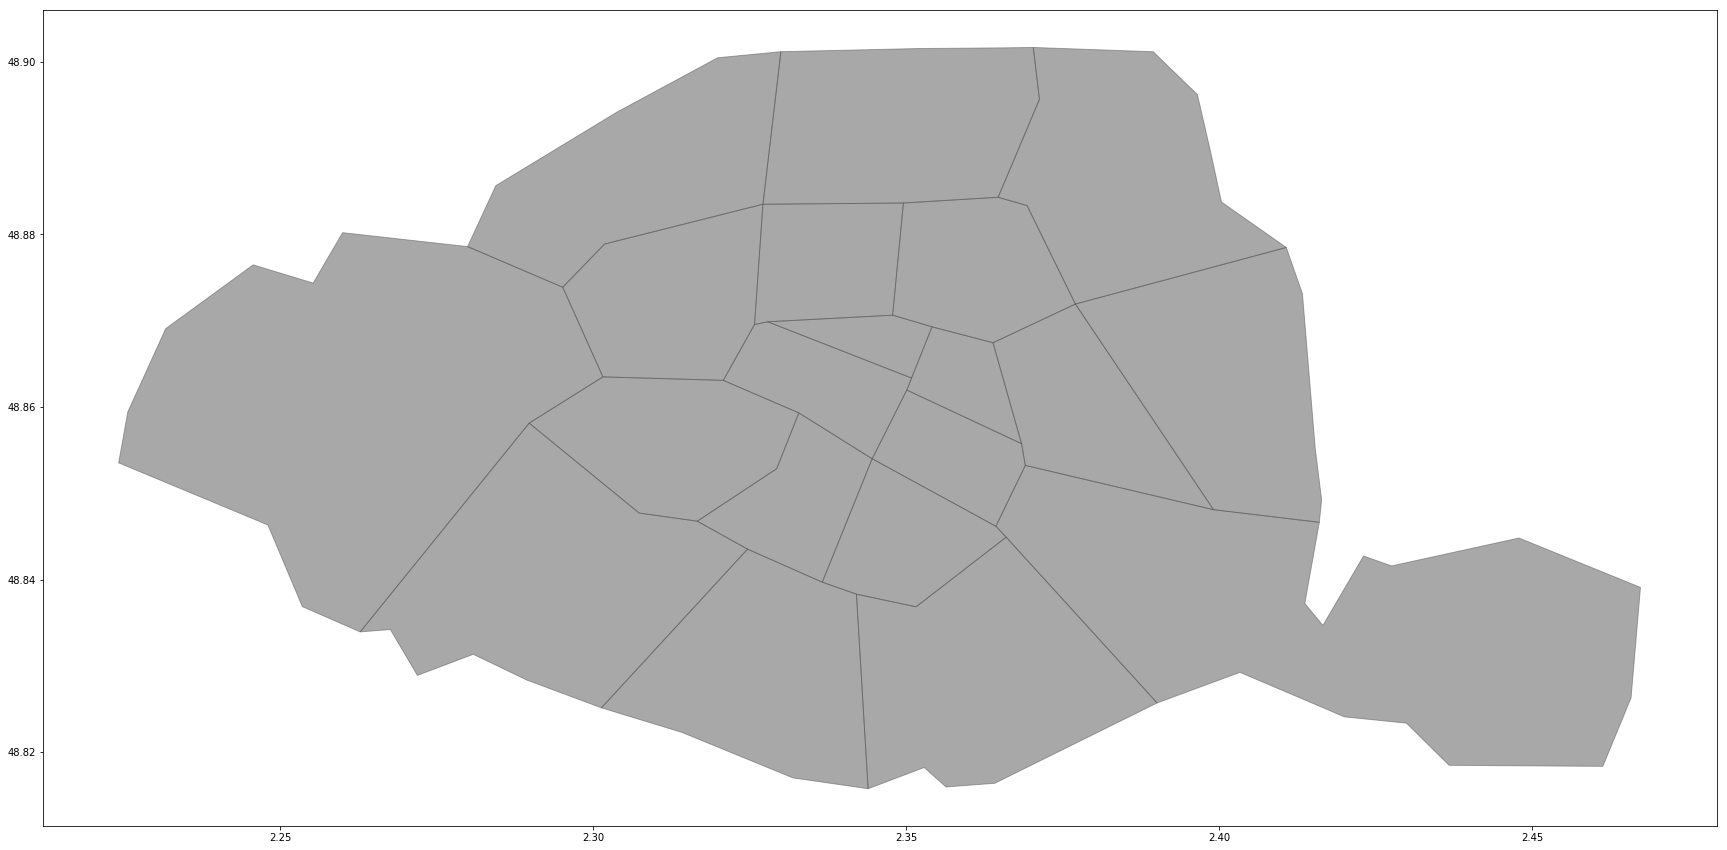

In [13]:
# Plot a map to check

f, ax = plt.subplots(figsize=(30,15))
gpd.plotting.plot_polygon_collection(ax,
                                     arr_bg['geometry'],
                                     linewidth=0.9,
                                     edgecolor='#B9EBE3',
                                    alpha=0.5,
                                    color='#525252');


#### Construct a geodataframe with geometries starting from gps coordinates

In [25]:
geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
crs=arr_bg.crs
geo_df = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

In [26]:
len(geometry)
geo_df.shape

60529

(60529, 25)

In [27]:
geo_df.head(2)

id  host_id  host_since host_is_superhost neighbourhood_cleansed  \
0  3109     3631  2008-10-14                 f           Observatoire   
1  5396     7903  2009-02-14                 t         Hôtel-de-Ville   

    latitude  longitude        room_type  square_feet  price  \
0  48.833494   2.318518  Entire home/apt          NaN     59   
1  48.851001   2.358690  Entire home/apt          NaN     93   

                      ...                       review_scores_location  \
0                     ...                                         10.0   
1                     ...                                         10.0   

   review_scores_value reviews_per_month calculated_host_listings_count  beds  \
0                 10.0              0.28                              1   1.0   
1                 10.0              1.20                              1   1.0   

   review_scores_accuracy  review_scores_cleanliness  \
0                    10.0                       10.0   
1                     9.0                        9.0   

   review_scores_communication  arrondissement  \
0                         10.0              14   
1                         10.0               4   

                                      geometry  
0  POINT (2.318517923068036 48.83349368980914)  
1   POINT (2.358690415243067 48.8510006715121)  

[2 rows x 25 columns]

In [17]:
# Check that coordinates are the same
geo_df.crs
arr_bg.crs

{'init': 'epsg:4326', 'no_defs': True}

{'init': 'epsg:4326', 'no_defs': True}

## Choropleth map:  price and rating by arrondissement

In [28]:
# Mean price and std by arr
myD = df.groupby(['arrondissement'])
agg = pd.core.groupby.GroupBy.aggregate
myD_av_price = myD['price'].agg(np.mean)
myD_std_price = myD['price'].agg(np.std)

# Mean evaluation location
myD = df.groupby(['arrondissement'])
agg = pd.core.groupby.GroupBy.aggregate
myD_av_eval = myD['review_scores_location'].agg(np.mean)
myD_std_eval = myD['review_scores_location'].agg(np.std)

# Mean evaluation value
myD = df.groupby(['arrondissement'])
agg = pd.core.groupby.GroupBy.aggregate
myD_av_value_eval = myD['review_scores_rating'].agg(np.mean)
myD_std_value_eval = myD['review_scores_rating'].agg(np.std)




I build a datframe with mean and std of price, overall rating, location rating, divided by arrondissement

In [29]:
mean_std_df = pd.DataFrame({'arrondissement':myD_std_price.index,
                            'mean_price':myD_av_price.values, 
                            'price_std':myD_std_price.values,
                           'eval_mean':myD_av_eval.values,
                           'eval_std':myD_std_eval.values,
                            'eval_mean_val':myD_av_value_eval.values,
                           'eval_std_val':myD_std_value_eval.values})
mean_std_df

arrondissement  mean_price   price_std  eval_mean  eval_std  \
0                1  149.591906  105.167331   9.893122  0.427108   
1                2  118.552095   81.936905   9.733117  0.569595   
2                3  129.393243   95.172378   9.860101  0.422763   
3                4  138.669565  102.389408   9.949068  0.268300   
4                5  112.599608   82.121630   9.843301  0.429984   
5                6  149.277496  124.848774   9.912890  0.405740   
6                7  153.119976  133.193524   9.897991  0.354547   
7                8  163.509383  146.744591   9.815978  0.552114   
8                9  104.830877   79.782600   9.753868  0.571759   
9               10   87.974156   60.881810   9.424426  0.759200   
10              11   82.157361   56.100909   9.633118  0.618093   
11              12   77.825112   52.515755   9.562260  0.658760   
12              13   76.118475   56.126860   9.437844  0.744235   
13              14   82.460042   61.865956   9.562114  0.684838   
14              15   94.474026   71.016966   9.643576  0.614660   
15              16  129.085742  115.463594   9.721784  0.633758   
16              17   90.677633   73.702356   9.524028  0.708946   
17              18   76.446514   51.408526   9.255994  0.938968   
18              19   69.464182   52.026652   9.266614  0.823464   
19              20   66.990474   45.490456   9.244212  0.813200   

    eval_mean_val  eval_std_val  
0        9.213108      0.881472  
1        9.182471      0.835892  
2        9.271061      0.825219  
3        9.277371      0.806612  
4        9.267284      0.787540  
5        9.239561      0.813510  
6        9.301846      0.775051  
7        9.189276      0.946489  
8        9.316554      0.837549  
9        9.307455      0.785767  
10       9.320489      0.776523  
11       9.300821      0.791527  
12       9.215998      0.903739  
13       9.268034      0.792294  
14       9.282139      0.836556  
15       9.228432      0.929078  
16       9.292814      0.817129  
17       9.306520      0.782581  
18       9.273051      0.879717  
19       9.300707      0.806780

From the dataframe built, I build a geodataframe adding geometries for each arrondissement

In [30]:
arr_bg = arr_bg[['INSEE_COM','geometry']].sort_values(by='INSEE_COM').reset_index(drop=True)
crs = arr_bg.crs #{'init': 'epsg:4326','no_defs': True}
geo_df_arr = gpd.GeoDataFrame(mean_std_df, crs=crs, geometry=arr_bg['geometry'])

In [53]:
params = {'legend.fontsize': 20}
plt.rcParams.update(params)

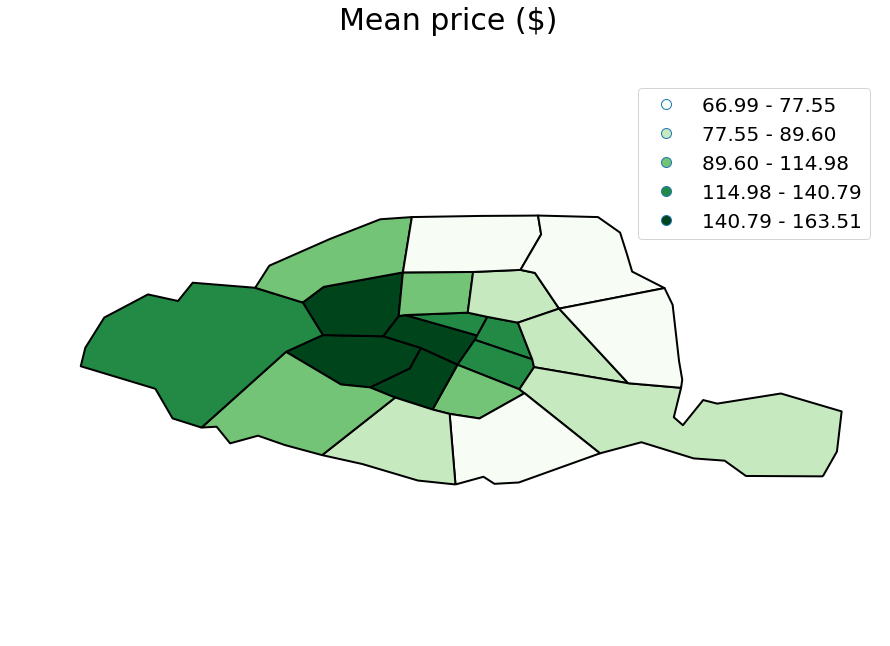

In [54]:
f, ax = plt.subplots(figsize=(15,10));

geo_df_arr.plot(column= 'mean_price', ax = ax, scheme='Quantiles', 
                cmap='Greens', legend=True, linewidth=2, edgecolor='black'
               );

ax.set_axis_off();
f.suptitle('Mean price ($)',fontsize=30);
plt.axis('equal');


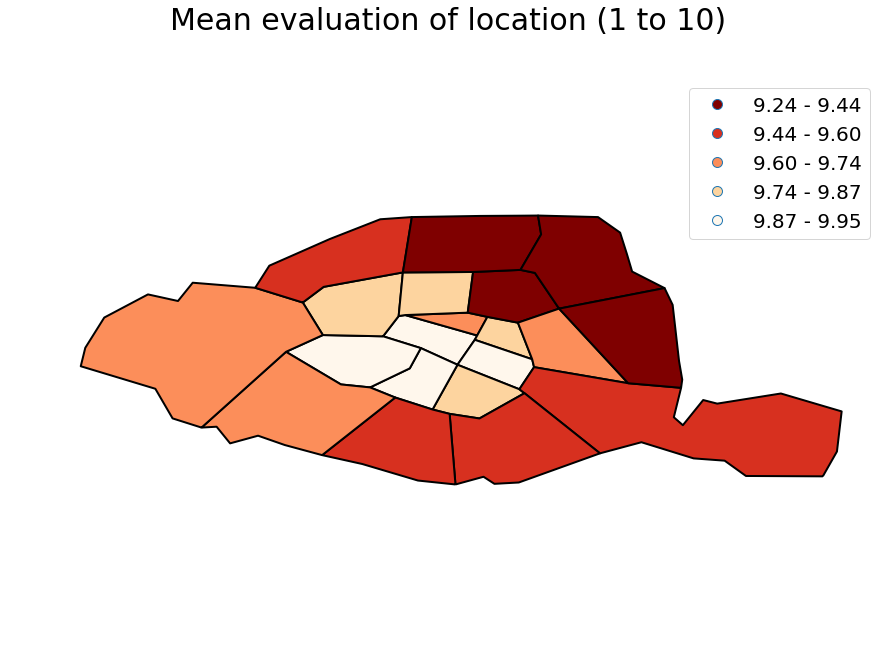

In [55]:

f, ax = plt.subplots(figsize=(15,10));

geo_df_arr.plot(column= 'eval_mean', ax = ax, scheme='Quantiles',
            cmap='OrRd_r', legend=True, linewidth=2, edgecolor='black');
ax.set_axis_off();
f.suptitle('Mean evaluation of location (1 to 10)',fontsize=30);
plt.axis('equal');



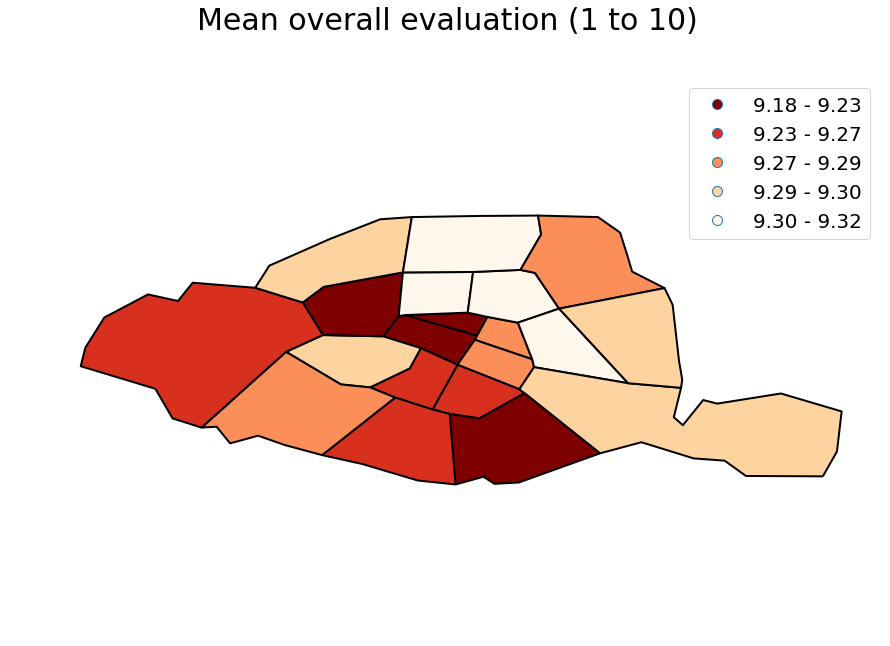

In [56]:

f, ax = plt.subplots(figsize=(15,10))

geo_df_arr.plot(column= 'eval_mean_val', ax = ax, scheme='Quantiles',
            cmap='OrRd_r', legend=True, linewidth=2, edgecolor='black')

ax.set_axis_off();
f.suptitle('Mean overall evaluation (1 to 10)', fontsize=30);
plt.axis('equal');


To do:
 - add number of arrondissements?
 - add location of monuments, to help localise the most touristic spots?

Quick comments: 
- The price distribution is not surprising: the most central/touristic neighbourhoods are more expensive. 
- The evaluation of the location tells that districts in the north-east of paris are less enjoyed by visitors . Those are the most multi-ethnical and low-income ones, but also the best for night-life. So, this may tell something both on the perception that people have of these areas  and on the interests of those who use airbnb: more interested to be closed to touristic spots than in nightlife (which may signal an interesting shift in the utilisation of this platform - from young travellers to more "traditional" tourists).
- But the most interesting comparison comes with the 3rd graph: the evaluation of the “overall experience” seems inverted with respect to location ! Namely, worst scores are given to some of the most central and expensive districts. This could be due to the fact that more people use airbnb as a business in the center, giving less care to their guests?

So, there's quite a few ideas to dig more : in particular to point 3 - are properties in the city center being used only to rent and not to live?

# Scatter Maps with geopandas

Cloropleth maps are good to catch trends at a glance, but I the results show the mean results by arrondissemsent. We have a lot more information in the dataset, i.e. the values for each airbnb in the list.
So, maybe a scatter map could give some more insight - or just be prettier. 

In [34]:
params = {'legend.fontsize': 45}
plt.rcParams.update(params)
color_list = ['green','lawngreen','yellow','gold','orange','orangered',
                'red', 'maroon', 'purple','black']

NOTE:

geopandas (and/or geoplot, which I recommend) both have options for producing scatter plot with different hues by category. However, I could not find some options that I'll need in the following, nemely the possibility to order manually the categories when coloring the points according to the value of some feature. 
So I did it by hand, adding different layers to the map.

The function below produces a scatter plot , coloring the points according to the value of the column "col", scaling their size and shading so that points with worst airbnb ratings are put in more evidence


In [77]:



def my_cat_plot(df, col, colors, reverse=False, star_normalise=True):

    f, ax = plt.subplots(figsize=(35,15));
    ax.set_aspect('equal');
    ax.set_axis_off();
    
    # Plot 1st layer: bg map
    geo_df_arr.plot(ax=ax, color='white', edgecolor='black',linewidth=2);

    df=df[df[col].notnull()]
    
    mymax=np.max(df[col].unique())
    mymin=np.min(df[col].unique())
    items = np.arange(1,mymax+1,1)
    if reverse:
        items=items[::-1]
     
    n=len(items)
    
    alpha_list=np.linspace(0.7,1,n)
    size_list=np.linspace(30,300,n)  
    
     
    # Add a layer for each category
    for i,star in enumerate(items):
        
        if star_normalise:
            my_label=star/len(items)*5
        else:
            my_label = star

        df_temp = df[df[col]==star]
    
        df_temp.plot(ax=ax, marker='.', markersize=size_list[i], label=my_label,
           column = col,  legend=False, color=colors[i],
                     alpha=alpha_list[i]);
    
        ax.legend()
   
    return f, ax


### Price (binned in price categories, from 1 to 10)

In [105]:
bins=[0,30,50,70,90,100,130,150,300,500,10000]
intervals = pd.cut(geo_df[geo_df.price.notnull()]['price'],
                           bins=bins).unique()
labels_names=[str(inter) for inter in intervals[:-1]]

In [106]:
geo_df['price_cat']=pd.cut(geo_df[geo_df.price.notnull()]['price'],
                           bins=bins,
                          labels=np.arange(1,11))

In [108]:
#Price categories:
labels_names

['(50, 70]',
 '(90, 100]',
 '(100, 130]',
 '(70, 90]',
 '(300, 500]',
 '(130, 150]',
 '(150, 300]',
 '(30, 50]',
 '(500, 10000]',
 '(0, 30]']

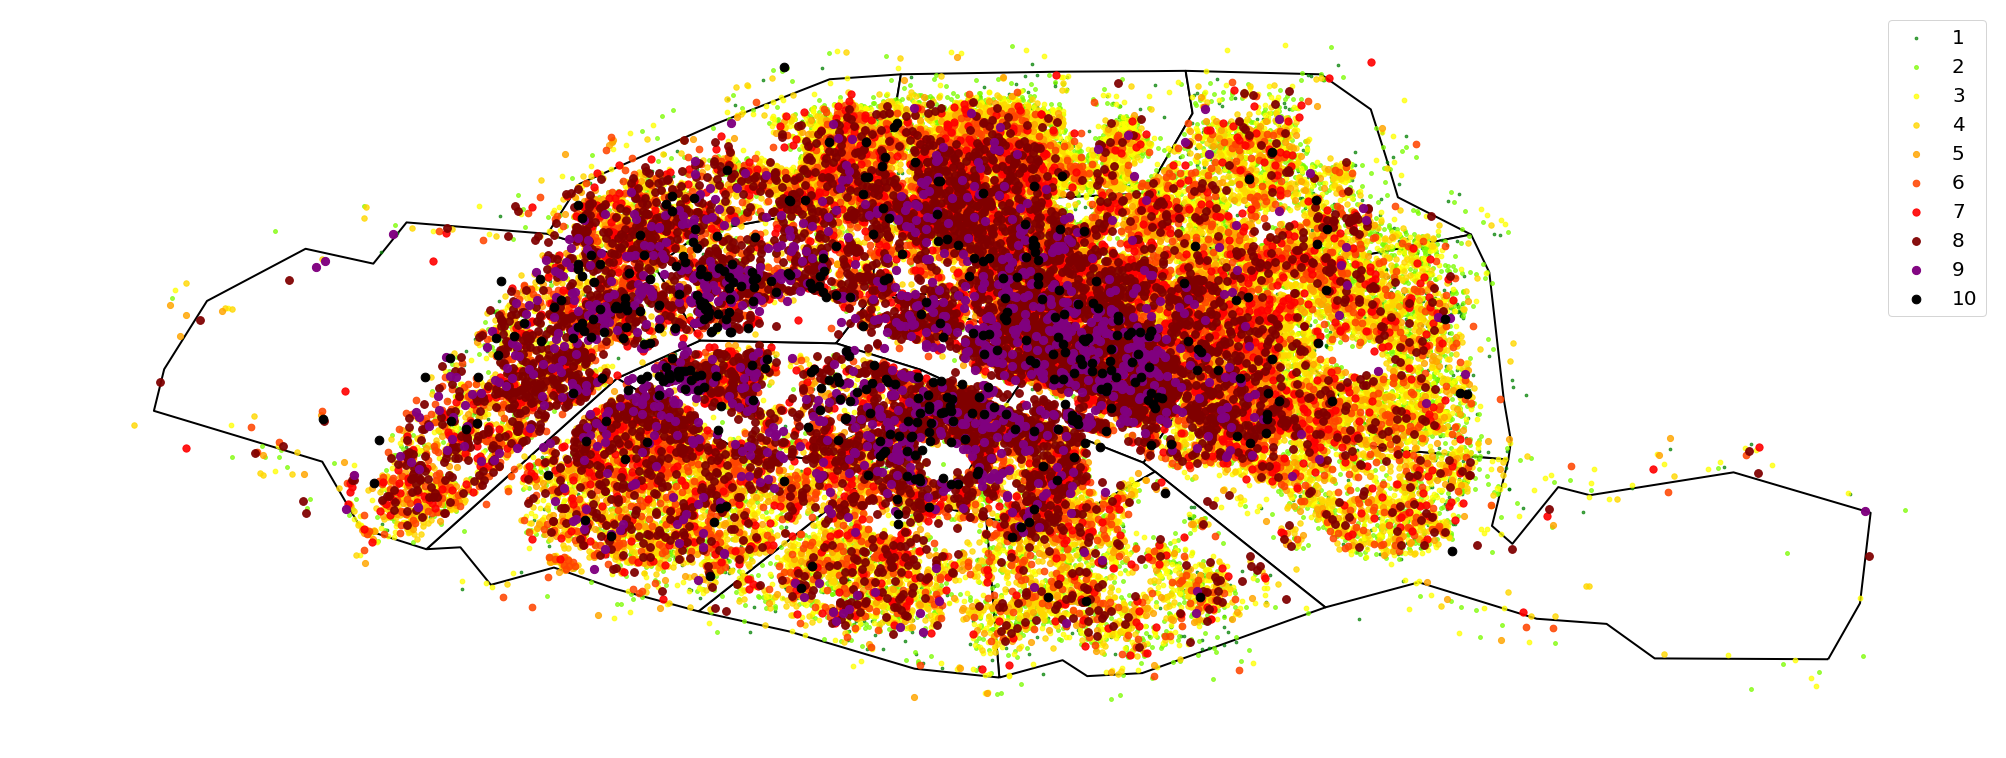

In [107]:
f_rev_score_location, ax_rev_score_location = my_cat_plot(geo_df, 'price_cat', 
                                        colors=color_list, reverse=False,
                                        star_normalise=False)

### Location review score (Airbnb stars)

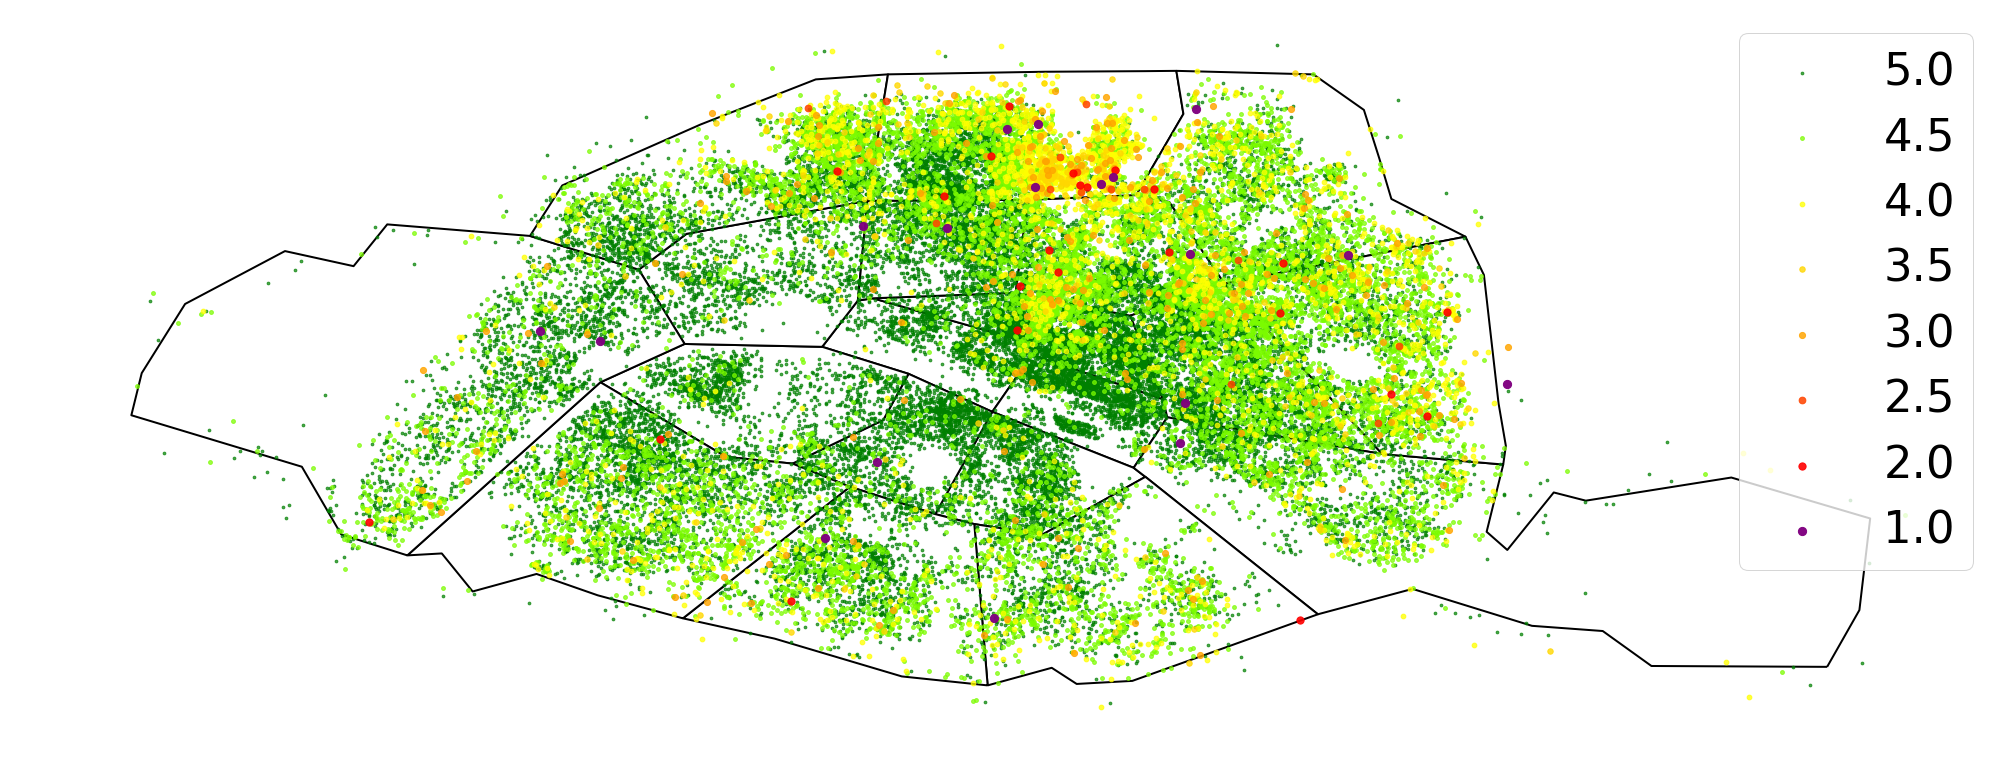

In [35]:
f_rev_score_location, ax_rev_score_location = my_cat_plot(geo_df, 'review_scores_location', 
                                        colors=color_list, reverse=True)

Uncomment below to add title

In [37]:
# f_rev_score_location.suptitle('Location review score (Airbnb stars)', fontsize=40);
# f_rev_score_location

### Overall review score (Airbnb stars)

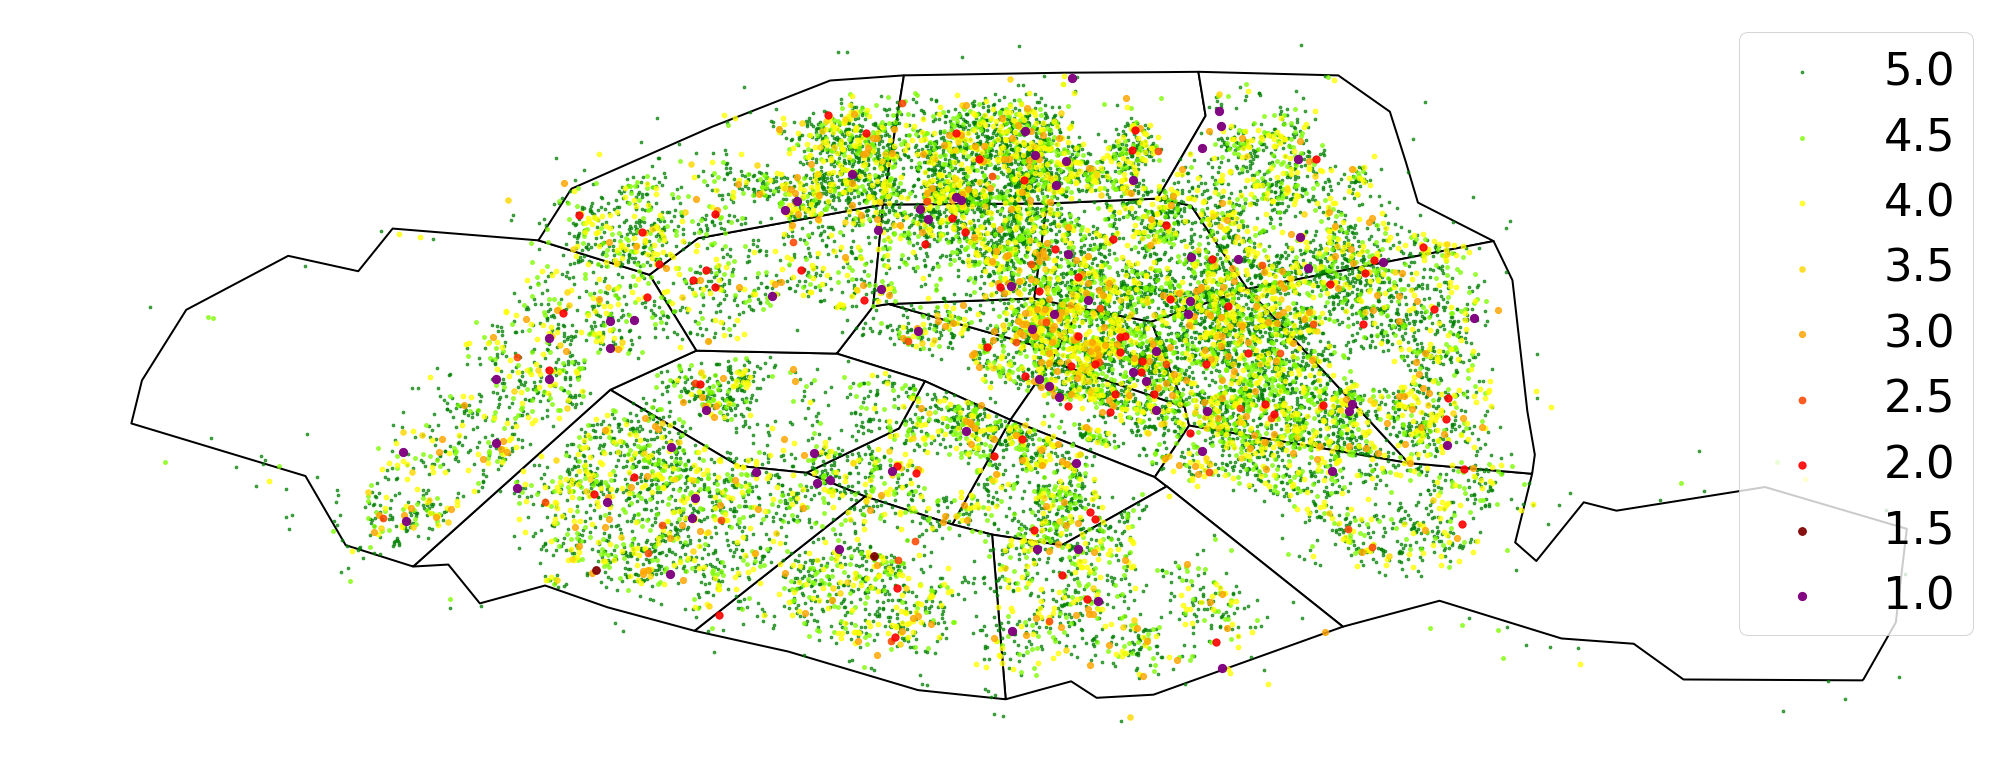

In [40]:
f_rev_score_rating, ax_rev_score_rating = my_cat_plot(geo_df, 'review_scores_rating', 
                                        colors=color_list, reverse=True)

Uncomment below to add title

In [41]:
# f_rev_score_rating.suptitle('Overall rating review score (Airbnb stars)', fontsize=40);
# f_rev_score_rating

### Value review score (Airbnb stars)

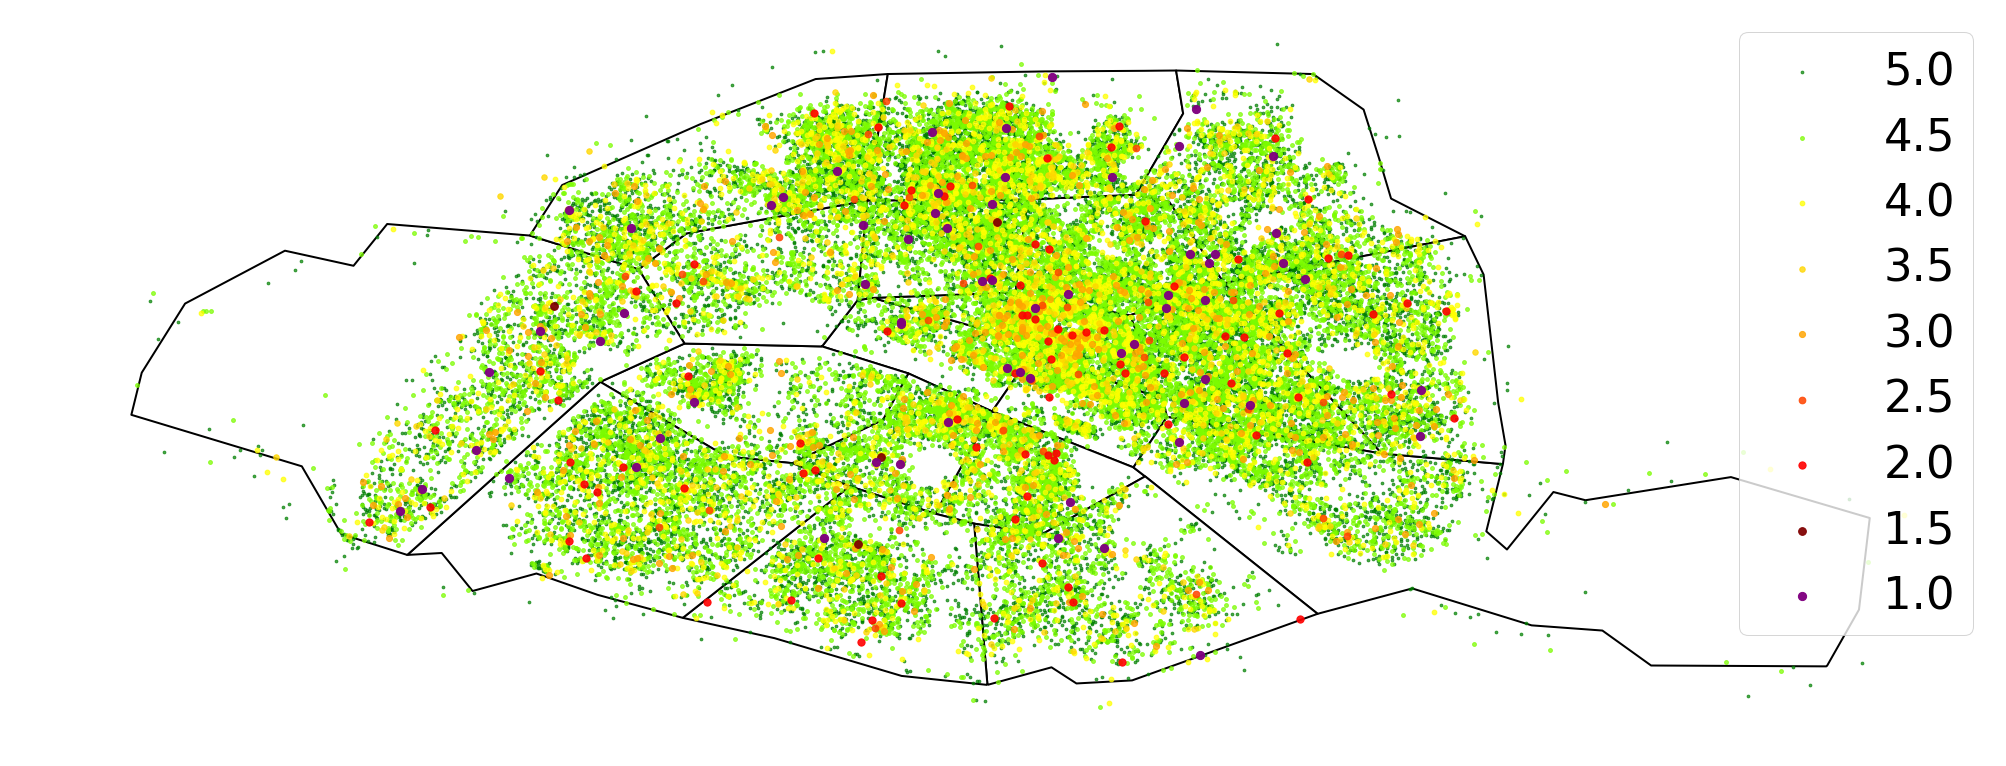

In [44]:
f_rev_score_value, ax_rev_score_value = my_cat_plot(geo_df, 'review_scores_value', 
                                        colors=color_list, reverse=True)

### Accuracy review score (Airbnb stars)

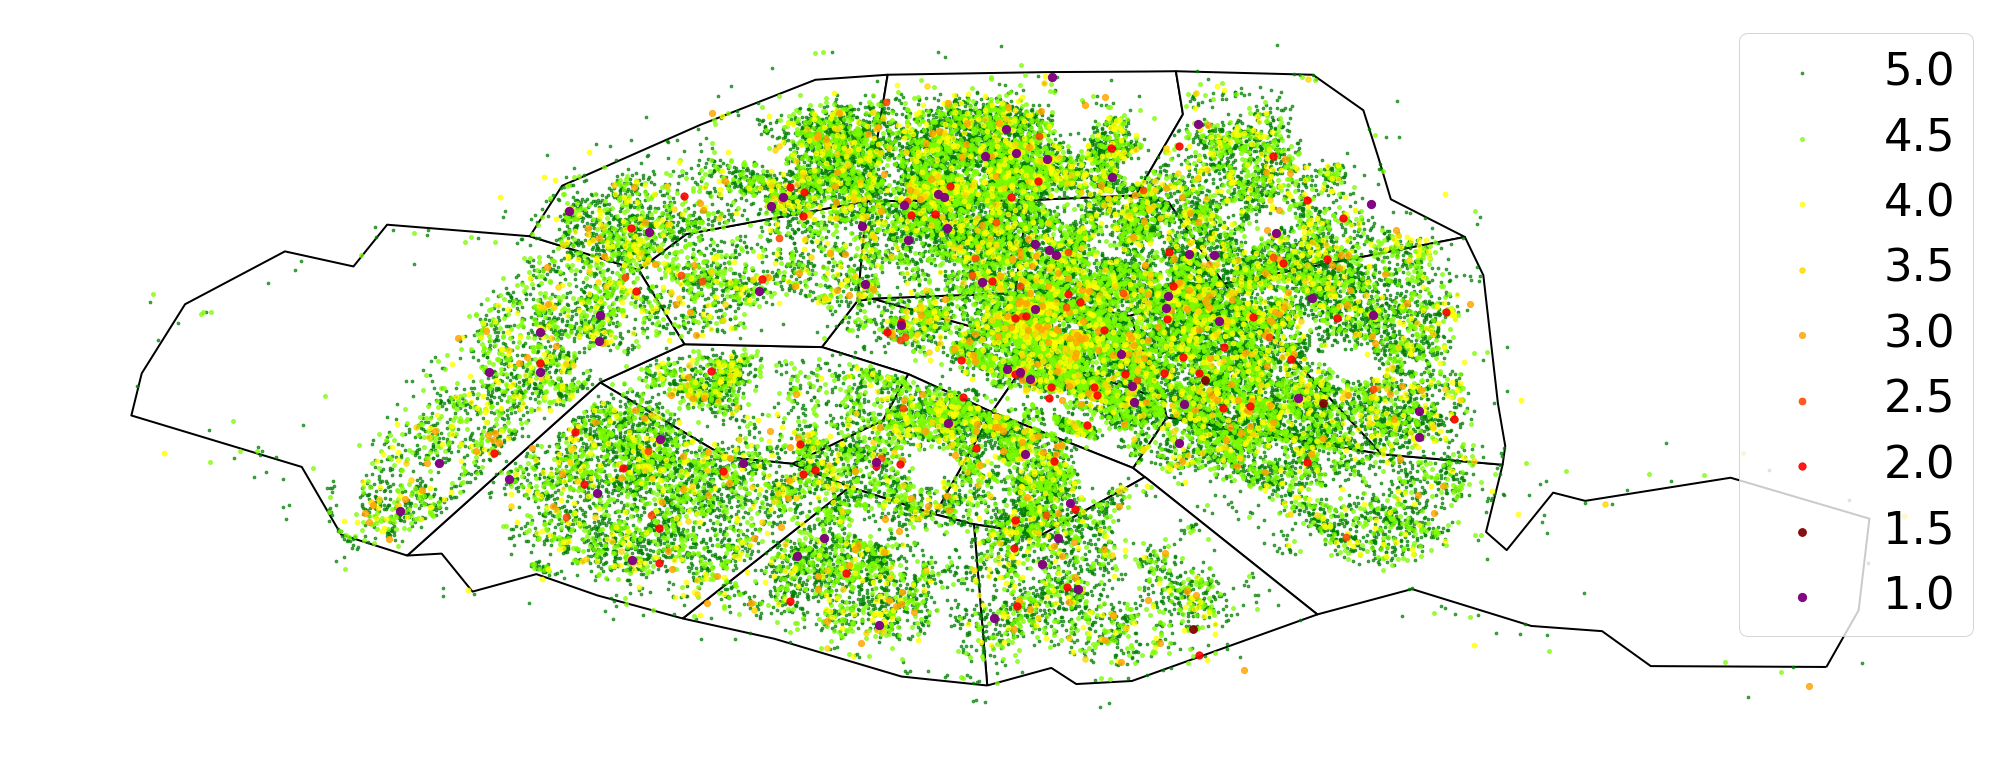

In [45]:
f_rev_score_value, ax_rev_score_value = my_cat_plot(geo_df, 'review_scores_accuracy', 
                                        colors=color_list, reverse=True)

### Communication review score (Airbnb stars)

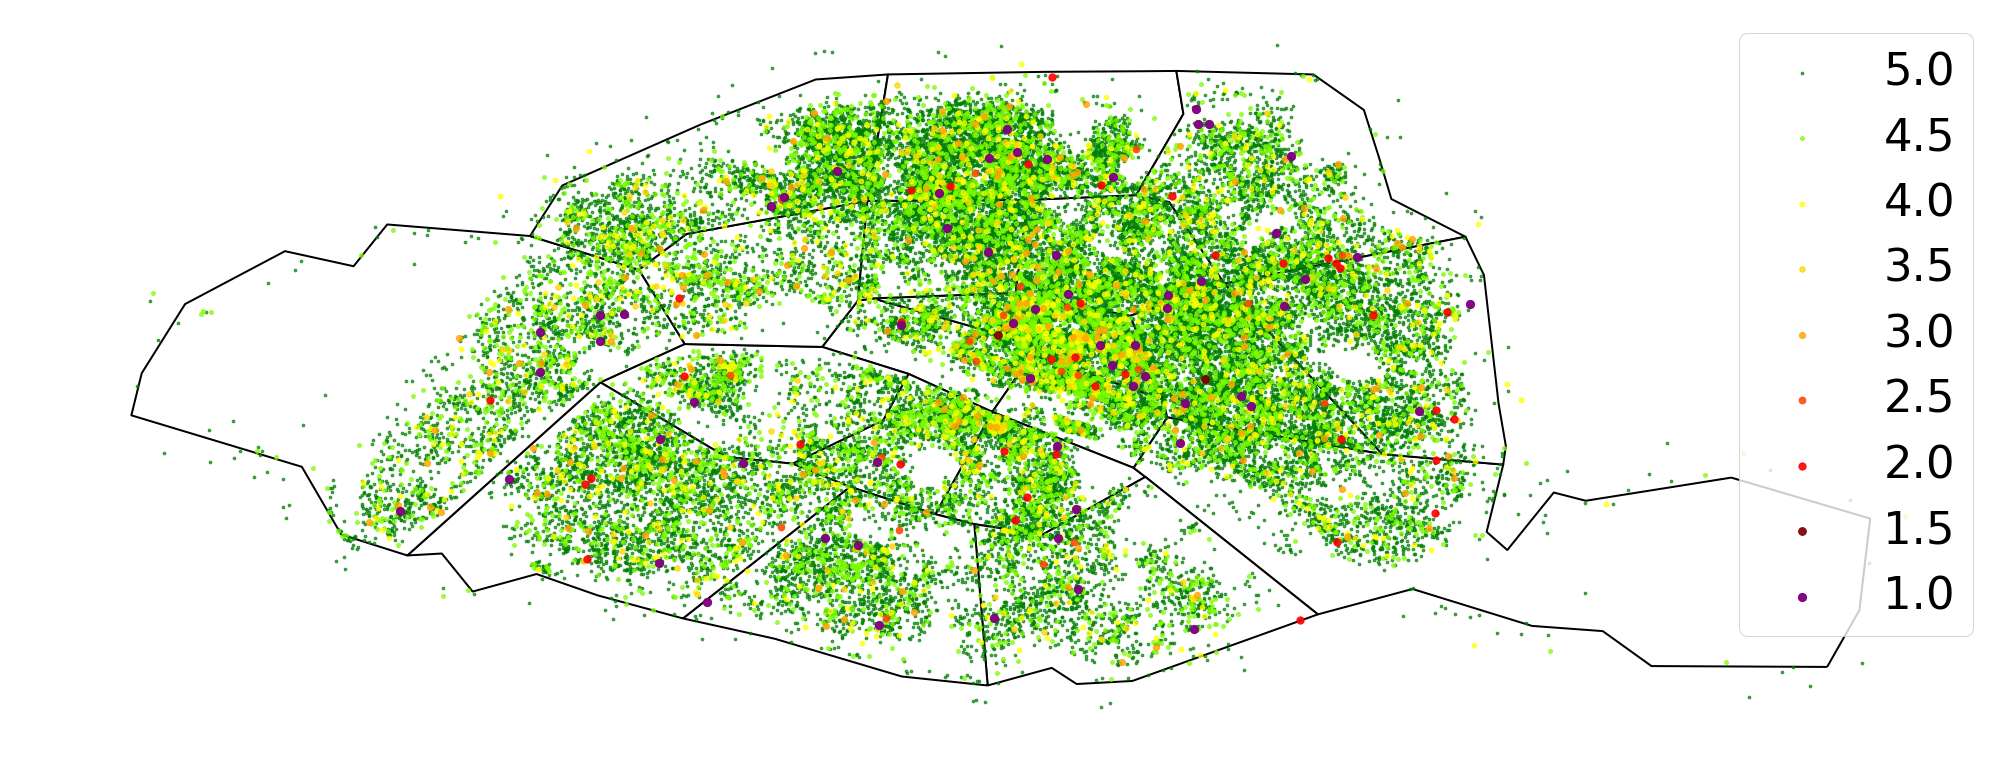

In [49]:
f_rev_score_value, ax_rev_score_value = my_cat_plot(geo_df, 'review_scores_communication', 
                                        colors=color_list, reverse=True)

### Cleanliness review score (Airbnb stars)

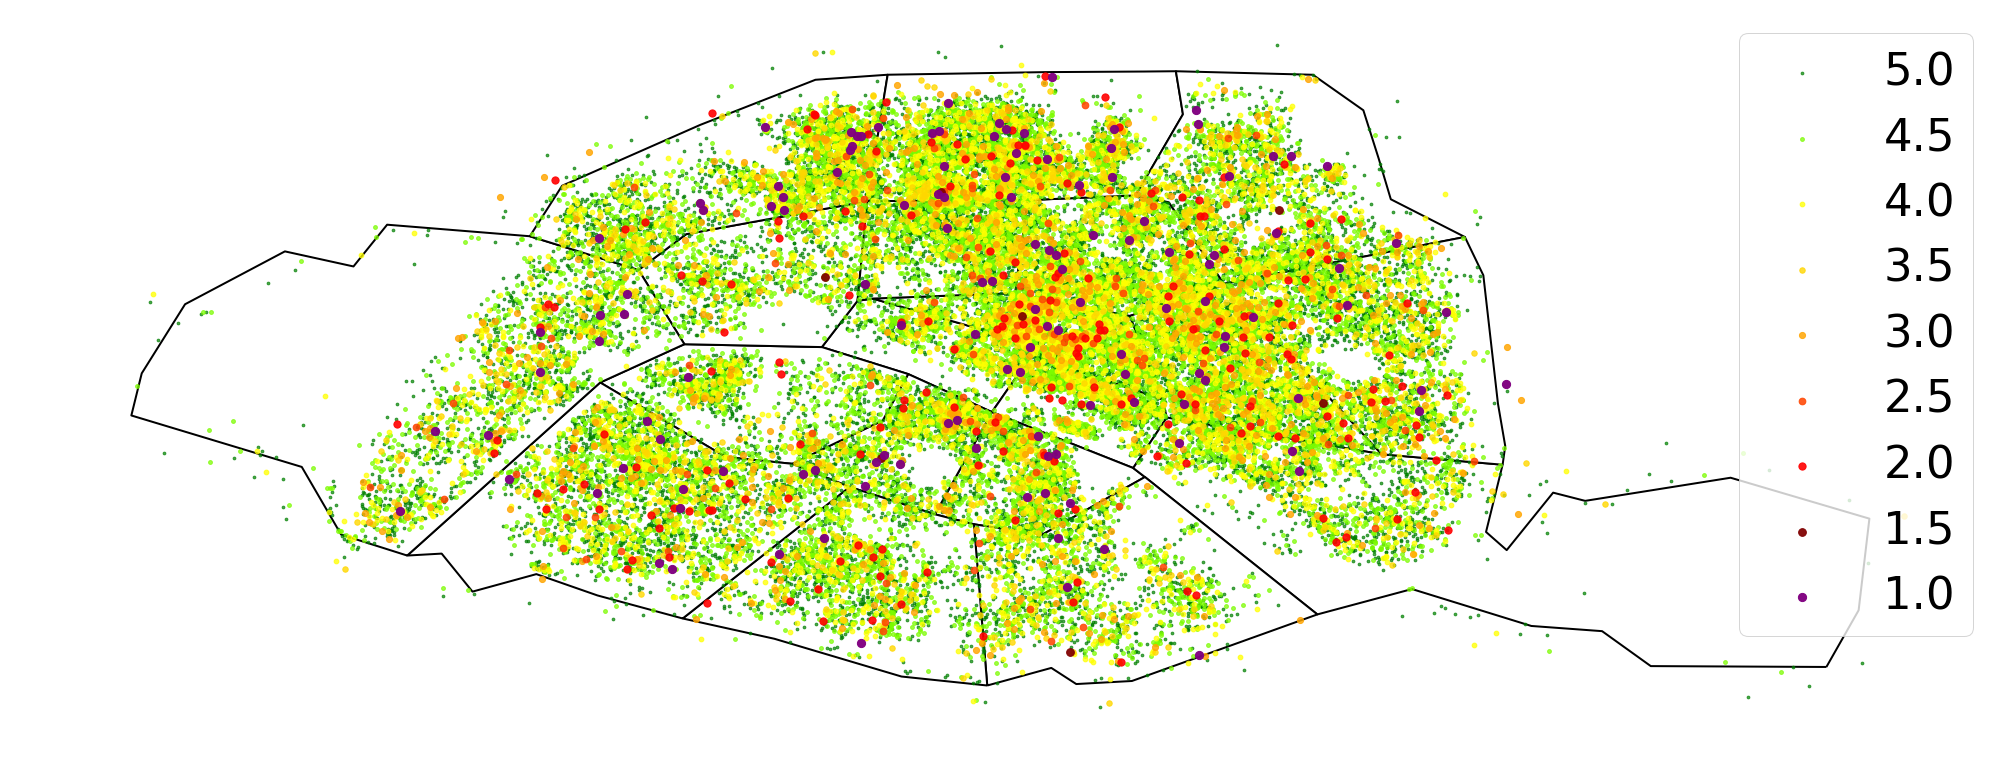

In [50]:
f_rev_score_value, ax_rev_score_value = my_cat_plot(geo_df, 'review_scores_cleanliness', 
                                        colors=color_list, reverse=True)

# To do

Related to the above maps:
 - Correlation among different review scores ? What drives the invertion location/overall ? 
 - Clean outliers in price, consider number of rooms/size

Understanding type of rents/comments:
 - Sentiment analysis on comments/reviews 

Study of gentrification:
 - Time evolution of price and other quantities: add past dataset/slice this one with since_id
 - Detection of owners of multiple rents
 - Check availability/number of reviews per month (if high, means that owner doens't live there...)
 - Add data: income, cost of life, avg. rent price, night-life, evictions, ....
 
 - Reproduce results of: http://insideairbnb.com/face-of-airbnb-nyc/